<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/labs/cs473_lab_week_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><p><b>After clicking the "Open in Colab" link, copy the notebook to your own Google Drive before getting started, or it will not save your work</b></p>

# BYU CS 473 Lab Week 12

## Introduction:

Label Propagation is a powerful semi-supervised learning algorithm designed to take advantage of the underlying structure in data when labeled examples are scarce. In many real-world scenarios, acquiring large amounts of labeled data for classification can be expensive or time-consuming, while vast quantities of unlabeled data are readily available. Semi-supervised methods like Label Propagation bridge this gap and enable models to make effective use of both labeled and unlabeled data.

In this lab, you will implement the Label Propagation algorithm on the provided Smiley Face Dataset.


---
## Grading standards   

Your notebook will be graded on the following:

* 40% Correct implementation of transition matrix
* 40% Correct implementation of label prop algorithm
* 20% Analysis


---

### Description

For this lab, you will use this dataset [lab_week_12_smiley_face.csv](https://github.com/wingated/cs473/blob/main/labs/data/lab_week_12_smiley_face.csv).

Download the csv from the link above, then upload the csv to your current google colab runtime.



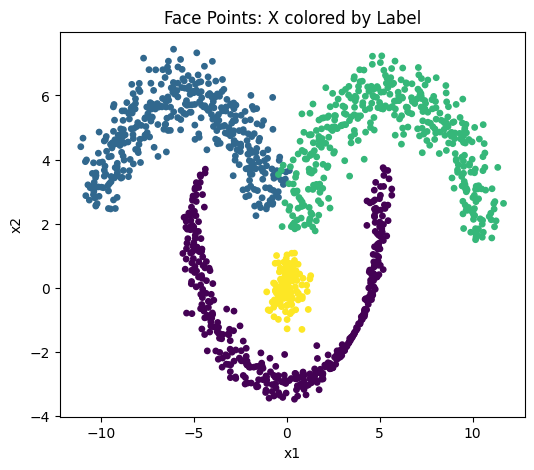

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# TODO: change path to your actual path
df = pd.read_csv('lab_week_12_smiley_face.csv')

X = df[['x1', 'x2']].values
y = df['label'].values

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X[:,0], X[:,1], marker='.', c=y, cmap='viridis', s=60)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Face Points: X colored by Label")
plt.show()


### Sample random labels

In a real problem where you would use Label Prop, you would have a limited number of datapoints that had labels. In this case, since you have access to each datapoint's labels, you will randomly sample the indices of $k$ datapoints and their labels. We will be experimenting with multiple values of $k$ later on, but start with $k = 10$.

Hints:

* np.random.permutation() is a helpful function for randomizing the order of the indices.

* Feel free to try to visualize which datapoints were chosen (you can create a new label vector where all entries are 0 except for the $k$ chosen indices)

In [2]:
# Sample random labels
k = 10

# Randomly permute all indices, then take the first k
perm = np.random.permutation(len(y))
labeled_indices = perm[:k]

# Create a label vector with 0 everywhere except for the chosen k points
y_sampled = np.zeros_like(y)
y_sampled[labeled_indices] = y[labeled_indices]

print("Chosen indices:", labeled_indices)
print("Sampled labels:", y_sampled[labeled_indices])

Chosen indices: [ 931  687  781 1062  713  403  559  535  469 1036]
Sampled labels: [2 1 1 2 1 1 1 1 1 2]


### Building the Transition Matrix

The transition matrix used in the Label Prop algorithm defines an N x N matrix (where N is the number of datapoints, labeled and unlabeled) where each entry is the measure of similarity between two datapoints so that each datapoint has a measure of similarity with each other datapoint. There are several ways to define this measure of similarity, and which measure you want to use will depend on your data. Since our data is made up of two-dimensional points, we can use Euclidean distance as our distance, but we need to convert this into a measure of similarity. You're going to do this by using an rbf kernel to compute similarity between each datapoint. Further details on the Label Prop algorithm are found on page 643 of the textbook.

1. Compute pairwise Euclidean distances between all points.

2. Convert distances to similarities using the RBF Kernel (use a sigma value of 0.1):

$\qquad W_{ij} = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)$

3. Normalize each row to ensure each row is a probability distribution (sums to 1):

$\qquad T_{ij} = \frac{W_{ij}}{\sum_j W_{ij}}$

In [3]:
from scipy.spatial.distance import cdist

# Compute pairwise Euclidean distances between all points
distances = cdist(X, X, metric='euclidean')

sigma = 0.1
W = np.exp(-distances**2 / (2 * sigma**2))

# Normalize each row so it sums to 1
T = W / W.sum(axis=1, keepdims=True)

print("Transition matrix shape:", T.shape)
print("Sum of first row (should be 1):", T[0].sum())

Transition matrix shape: (1320, 1320)
Sum of first row (should be 1): 1.0


### Create Y Matrix

$Y$ is an $N$ x $C$ label matrix where $C$ is the number of possible classes (in this case, 4). From the textbook: "The $ith$ row of $Y$ represents the class probability distribution of datapoint $i$."

1. Initialize $Y$ so each datapoint has a uniform probability over the 4 classes (0.25).

2. Get the true labels for the $k$ chosen datapoints from earlier.

3. For each index that was chosen as a labeled datapoint, change its value in $Y$ to be a one hot encoding of the class label (for example, if the true label is 1, the one hot encoding would be: [0, 1, 0, 0]).

In [4]:
num_classes = 4
N = X.shape[0]

# Uniform probability for each class
Y = np.ones((N, num_classes)) / num_classes

for idx in labeled_indices:
    label = y[idx]           # true label of this datapoint
    Y[idx] = np.zeros(num_classes)  # reset to zero
    Y[idx, label] = 1               # one-hot encoding

print("Y matrix shape:", Y.shape)
print("Example rows of Y:")
print(Y[:10])

Y matrix shape: (1320, 4)
Example rows of Y:
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


### Label Propagation Algorithm

Follow the algorithm as described in the middle of page 643 of the textbook.

1. Use the transition matrix $T$ to propagate labels in $Y$ by setting $Y$ = $TY$.

2. Re-normalize the rows of $Y$ by setting $Y_{i,c} = \frac{Y_{i,c}}{\sum_{k}{Y_{i,k}}}$

3. Replace the rows of $Y$ corresponding to the labeled datapoints with their one-hot representation (i.e. $Y_{i,c}=1$ if datapoint $i$ has ground-truth label $c$ and $0$ otherwise)

4. Repeat until convergence. Check for convergence by comparing the previous iteration's $Y$ to the current iteration's $Y$. (Hint: try using a tolerance of 1e-4)

5. After convergence, guessed labels are chosen based on the highest class probability for each datapoint in $Y$.

6. During each iteration, save a temporary label vector of what each datapoint's class would be if that were the final iteration. Save each of these to a list called labels_by_iter to help with the visualization after the algorithm completes.


In [5]:
# Label Propagation Algorithm
labels_by_iter = []

# Set parameters
tol = 1e-4       # convergence tolerance
max_iter = 50000  # safety limit to prevent infinite loop

# Save one-hot for labeled points to re-apply at each iteration
Y_labeled = np.copy(Y[labeled_indices])

converged = False

for iteration in range(max_iter):
    Y_prev = Y.copy()

    # Propagate labels
    Y = T @ Y

    # Normalize rows to make them probability distributions
    Y = Y / Y.sum(axis=1, keepdims=True)

    # Re-apply the true labels for labeled points
    Y[labeled_indices] = Y_labeled

    # Save temporary label guesses
    temp_labels = np.argmax(Y, axis=1)
    labels_by_iter.append(temp_labels)

    # Check for convergence
    if np.linalg.norm(Y - Y_prev) < tol:
        print(f"Converged in {iteration+1} iterations")
        converged = True
        break

# Final guessed labels
final_labels = np.argmax(Y, axis=1)

if not converged:
    print(f"Did not converge in {max_iter} iterations")
print("Final guessed labels:", final_labels)

Converged in 39834 iterations
Final guessed labels: [1 1 1 ... 1 1 1]


### Visualization



In [6]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def plot_label_propagation(iter_num):
    plt.figure(figsize=(6, 6))
    labels = labels_by_iter[iter_num]
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
    plt.title(f'Label Propagation Iteration {iter_num}')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True)
    plt.clim(-0.5, labels_by_iter[0].max() + 0.5)
    plt.show()

n_iters = len(labels_by_iter)
interact(plot_label_propagation,
         iter_num=IntSlider(min=0, max=n_iters-1, step=1, value=0, description='Iteration'))


interactive(children=(IntSlider(value=0, description='Iteration', max=39833), Output()), _dom_classes=('widget…

<function __main__.plot_label_propagation(iter_num)>

### Analysis

Run your algorithm with at least 5 values of $k$ that are all within the range of 1-20. Then look at the visualization for each value of k and answer the following questions:

* How does the value of $k$ affect the speed of convergence?

* Are there any values of $k$ that change the end state of the converged algorithm?

How does the value of  𝑘  affect the speed of convergence?

The general pattern is that as k increases, convergence is reached more quickly.

When k = 1, it takes 2436 iterations to converge.

When k = 5, it takes over 50000 iterations to converge.

When k = 10, it takes 47732 iterations to converge.

When k = 15, it takes 38383 iterations to converge

When k = 20, it takes 35234 iterations to converge

---

Are there any values of  𝑘  that change the end state of the converged algorithm?

The larger k is, the more likely we are to get at least one sample of each class. If k < num_classes, there is no way for every class to be represented in the end state. Beyond a given test case choosing a significantly disproportionate representation of one or more classes, the value of k doesn't seem to have a direct and significant impact on the end state.